<a href="https://colab.research.google.com/github/VishnuPy/MyPython/blob/master/PredictNaN_BC_Prj_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls

Found GPU at: /device:GPU:0
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
'My Drive'/


In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

W0828 06:51:46.966403 139697492125568 deprecation.py:323] From <ipython-input-2-00b17d59170f>:10: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0828 06:51:46.973981 139697492125568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.546702371999345
GPU (s):
0.9664423000003808
GPU speedup over CPU: 3x


In [0]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  

from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

NaN_data = pd.read_csv('My Drive/MyLearning/MLDLAIPython/Data/TextData/NaN_Predict_train.csv')
NaN_data.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Bare Nuclei
0,1000025,5,1,1,1,2,3,1,1,2,1
1,1002945,5,4,4,5,7,3,2,1,2,10
2,1015425,3,1,1,1,2,3,1,1,2,2
3,1016277,6,8,8,1,3,3,7,1,2,4
4,1017023,4,1,1,3,2,3,1,1,2,1


In [0]:
NaN_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sample code number,683.0,1.076720e+06,620644.047655,63375.0,877617.0,1171795.0,1238705.0,13454352.0
Clump Thickness,683.0,4.442167e+00,2.820761,1.0,2.0,4.0,6.0,10.0
Uniformity of Cell Size,683.0,3.150805e+00,3.065145,1.0,1.0,1.0,5.0,10.0
Uniformity of Cell Shape,683.0,3.215227e+00,2.988581,1.0,1.0,1.0,5.0,10.0
Marginal Adhesion,683.0,2.830161e+00,2.864562,1.0,1.0,1.0,4.0,10.0
Single Epithelial Cell Size,683.0,3.234261e+00,2.223085,1.0,2.0,2.0,4.0,10.0
Bland Chromatin,683.0,3.445095e+00,2.449697,1.0,2.0,3.0,5.0,10.0
Normal Nucleoli,683.0,2.869693e+00,3.052666,1.0,1.0,1.0,4.0,10.0
Mitoses,683.0,1.603221e+00,1.732674,1.0,1.0,1.0,1.0,10.0
Class,683.0,2.699854e+00,0.954592,2.0,2.0,2.0,4.0,4.0


In [0]:
corr_matrix = NaN_data.corr()
corr_matrix['Bare Nuclei'].sort_values(ascending=False)

Bare Nuclei                    1.000000
Class                          0.822696
Uniformity of Cell Shape       0.713878
Uniformity of Cell Size        0.691709
Bland Chromatin                0.680615
Marginal Adhesion              0.670648
Clump Thickness                0.593091
Single Epithelial Cell Size    0.585716
Normal Nucleoli                0.584280
Mitoses                        0.339210
Sample code number            -0.099248
Name: Bare Nuclei, dtype: float64

In [0]:
NaN_data.Class[NaN_data.Class == 4] = 1
NaN_data.Class[NaN_data.Class == 2] = 0

In [0]:
X = NaN_data.iloc[:, 1:10]
y = NaN_data.iloc[:, 10]
#X = NaN_data.iloc[:, :-1].values
#y = NaN_data.iloc[:, 10].values

In [0]:
y.head()

0     1
1    10
2     2
3     4
4     1
Name: Bare Nuclei, dtype: int64

In [0]:
print ('X.shape -- > ', X.shape)
print ('y.shape -- > ', y.shape)

X.shape -- >  (683, 9)
y.shape -- >  (683,)


In [0]:
X.isnull().sum()

Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20)

In [0]:
iter=12

In [0]:
# search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 21)
# empty list to store scores
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())


print(k_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number 

[0.6314425151731653, 0.6415923560443684, 0.6816045523104346, 0.698324795947087, 0.7110776736163732, 0.7192090324536144, 0.7277595603570836, 0.7277595603570836, 0.7315493227103135, 0.7429557398226129, 0.7500919627328296, 0.7523507039915709, 0.7523507039915709, 0.7541311784191042, 0.7541311784191042, 0.7541311784191042, 0.7544252960661629, 0.7540919627328296, 0.7540919627328296, 0.7540919627328296]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [0]:
# in essence, this is basically running the k-fold cross-validation method 30 times because we want to run through K values from 1 to 30
# we should have 30 scores here
print('Length of list', len(k_scores))
print('Max of list', max(k_scores))

Length of list 20
Max of list 0.7544252960661629


Length of list 35
Max of list 0.7386185722935326

In [0]:

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[73  0  0  0  0  0  0  0  0  3]
 [ 4  0  0  0  0  0  0  0  0  2]
 [ 3  0  0  0  0  0  0  0  0  2]
 [ 1  0  0  0  0  0  0  0  0  3]
 [ 1  0  0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  4]
 [ 2  0  0  0  0  0  0  0  0 26]]
              precision    recall  f1-score   support

           1       0.87      0.96      0.91        76
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         4
          10       0.49      0.93      0.64        28

    accuracy                           0.72       137
   macro avg       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
error = []
accuracy = []

# Calculating error for K values between 1 and 40
for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    score = accuracy_score(y_test, pred_i)
    accuracy.append(score)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

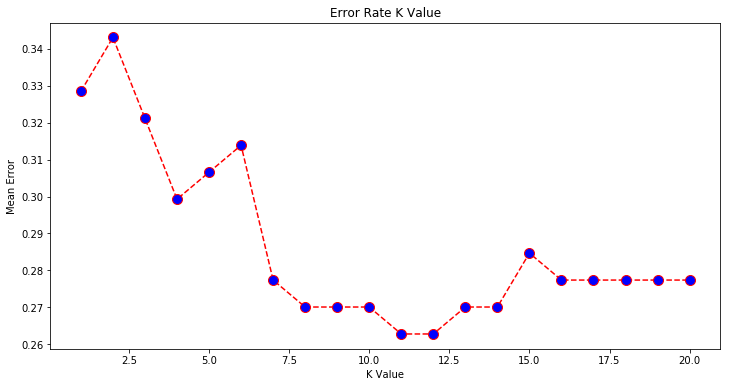

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [0]:
NaN_miss = pd.read_csv('My Drive/MyLearning/MLDLAIPython/Data/TextData/NaN_Predict_test.csv')
NaN_miss.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1057013,8,4,5,1,2,7,3,1,4
1,1096800,6,6,6,9,6,7,8,1,2
2,1183246,1,1,1,1,1,2,1,1,2
3,1184840,1,1,3,1,2,2,1,1,2
4,1193683,1,1,2,1,3,1,1,1,2


In [0]:
X_train.iloc[:16,:]

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
502,1,1,1,1,1,2,1,1,0
235,2,1,1,1,2,3,1,1,0
530,5,1,1,1,2,2,1,1,0
316,10,4,7,2,2,6,1,1,1
187,1,1,1,1,2,3,1,1,0
426,5,2,2,4,2,1,1,1,0
190,8,4,4,5,4,7,8,2,0
457,6,1,1,1,1,1,1,1,0
161,10,8,10,10,6,3,1,10,1
463,5,2,1,1,2,1,1,1,0


In [0]:
#for i in range (1,16):
  #print (NaN_miss.iloc[i-1:i, 0:1])

In [0]:

knn = KNeighborsClassifier(20)
knn.fit(X_train, y_train)
for i in range (1,17):
  pred_mis_i = knn.predict(NaN_miss.iloc[i-1:i, 1:])    
  print('prediction for ',NaN_miss.iloc[i:i+1, 0:1], ' i value is -- > ', i,' predict class -- > ', pred_mis_i)
 

prediction for     Sample code number
1             1096800  i value is -- >  1  predict class -- >  [10]
prediction for     Sample code number
2             1183246  i value is -- >  2  predict class -- >  [10]
prediction for     Sample code number
3             1184840  i value is -- >  3  predict class -- >  [1]
prediction for     Sample code number
4             1193683  i value is -- >  4  predict class -- >  [1]
prediction for     Sample code number
5             1197510  i value is -- >  5  predict class -- >  [1]
prediction for     Sample code number
6             1241232  i value is -- >  6  predict class -- >  [1]
prediction for     Sample code number
7              169356  i value is -- >  7  predict class -- >  [1]
prediction for     Sample code number
8              432809  i value is -- >  8  predict class -- >  [1]
prediction for     Sample code number
9              563649  i value is -- >  9  predict class -- >  [1]
prediction for      Sample code number
10            

In [0]:
print ('Mean Accuracy: ', np.array(accuracy).mean(), ';  Min Accuracy: ', np.array(accuracy).min(), ';   Max Accuracy: ', np.array(accuracy).max())

Mean Accuracy:  0.7131386861313869 ;  Min Accuracy:  0.656934306569343 ;   Max Accuracy:  0.7372262773722628


In [0]:
pred_mis_i = knn.predict(NaN_miss.iloc[0:, 1:])    
print('prediction for ',NaN_miss.iloc[0:i, 0:1], ' i value is -- > ', 0,' predict class -- > ', pred_mis_i)

prediction for      Sample code number
0              1057013
1              1096800
2              1183246
3              1184840
4              1193683
5              1197510
6              1241232
7               169356
8               432809
9               563649
10              606140
11               61634
12              704168
13              733639
14             1238464
15             1057067  i value is -- >  0  predict class -- >  [10 10  1  1  1  1  1  1  1 10  1  1 10  1  1  1]


<font color=brown size = 5>
Stratified K Fold Approach

In [0]:
from sklearn.model_selection import StratifiedKFold

accuracy = []

skf = StratifiedKFold(n_splits=6, random_state=None)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
  print ('Train: ', train_index, ';     Validations:', test_index)
  X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
  y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]
  knn.fit(X1_train, y1_train)
  prediction = knn.predict(X1_test)
  score = accuracy_score(prediction, y1_test)
  accuracy.append(score)

print(accuracy)


Train:  [ 38  66  69  73  76  81  82  84  96 101 103 107 108 109 111 112 113 114
 116 117 119 122 133 139 140 141 142 143 144 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314
 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 36

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=6.
  % (min_groups, self.n_splits)), Warning)


In [0]:
np.array(accuracy).mean()

0.7473410201846868

In [0]:
print ('Mean Accuracy: ', np.array(accuracy).mean(), ';  Min Accuracy: ', np.array(accuracy).min(), ';   Max Accuracy: ', np.array(accuracy).max())

Mean Accuracy:  0.7473410201846868 ;  Min Accuracy:  0.6923076923076923 ;   Max Accuracy:  0.7837837837837838


In [0]:
for i in range (1,17):
  pred_mis_i = knn.predict(NaN_miss.iloc[i-1:i, 1:])    
  print('prediction for ',NaN_miss.iloc[i:i+1, 0:1], ' i value is -- > ', i,' predict class -- > ', pred_mis_i)

prediction for     Sample code number
1             1096800  i value is -- >  1  predict class -- >  [10]
prediction for     Sample code number
2             1183246  i value is -- >  2  predict class -- >  [10]
prediction for     Sample code number
3             1184840  i value is -- >  3  predict class -- >  [1]
prediction for     Sample code number
4             1193683  i value is -- >  4  predict class -- >  [1]
prediction for     Sample code number
5             1197510  i value is -- >  5  predict class -- >  [1]
prediction for     Sample code number
6             1241232  i value is -- >  6  predict class -- >  [1]
prediction for     Sample code number
7              169356  i value is -- >  7  predict class -- >  [1]
prediction for     Sample code number
8              432809  i value is -- >  8  predict class -- >  [1]
prediction for     Sample code number
9              563649  i value is -- >  9  predict class -- >  [1]
prediction for      Sample code number
10            

In [0]:
print (122000/5250)

23.238095238095237
